In [24]:
#When running the code to get correct results use Run all every time instead of running every cell individually

In [25]:
#install Packages if needed(uncomment them run them, if needed)
#packages can also be installed in Jupyter, command: !pip install packageName

#!pip install findspark
#!pip install pyspark

#!pip install jupyter
#!pip install pip
#!pip install pandas
#!pip install numpy
#!pip install matplotlib
#!pip install matplotlib-inline
#!pip install seaborn

In [26]:
#To import, enable, initalise spark into jupyter
#!pip install findspark
#!pip install pyspark

import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
df = spark.sql("select 'Spark' as Hello")
#df = spark.sql("select 'spark', 'myron' as hello")
df.show()


+-----+
|Hello|
+-----+
|Spark|
+-----+



In [27]:
df = spark.read.csv("BrokenDataset.csv", inferSchema = True, header = True)
df.show()
#df.printSchema()

+------+--------------+---------------------------+------------+-----------------------+----------+-------------+-------------+
|gender|race/ethnicity|parental level of education|       lunch|test preparation course|math score|reading score|writing score|
+------+--------------+---------------------------+------------+-----------------------+----------+-------------+-------------+
|female|       group B|          bachelor's degree|    standard|                   none|        72|           72|           74|
|female|       group C|               some college|    standard|              completed|        69|           90|           88|
|female|       group B|            master's degree|    standard|                   none|        90|           95|           93|
|  male|       group A|         associate's degree|free/reduced|                   none|        47|           57|           44|
|  male|       group C|               some college|    standard|                   none|        76|     

In [28]:
#counting the number of null and NaN fileds, does not include NULL, missing vlaues and string values

import numpy as np
from pyspark.sql.functions import col, isnan, when, count

df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------+--------------+---------------------------+-----+-----------------------+----------+-------------+-------------+
|gender|race/ethnicity|parental level of education|lunch|test preparation course|math score|reading score|writing score|
+------+--------------+---------------------------+-----+-----------------------+----------+-------------+-------------+
|    15|             0|                          9|    8|                     11|         1|            6|            1|
+------+--------------+---------------------------+-----+-----------------------+----------+-------------+-------------+



In [29]:
# Find count for empty, None, Null, Nan with string literals.
import numpy as np
from pyspark.sql.functions import col, isnan, when, count

df2 = df.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c 
                           )).alias(c)
                    for c in df.columns])
df2.show()

+------+--------------+---------------------------+-----+-----------------------+----------+-------------+-------------+
|gender|race/ethnicity|parental level of education|lunch|test preparation course|math score|reading score|writing score|
+------+--------------+---------------------------+-----+-----------------------+----------+-------------+-------------+
|    15|             0|                          9|    8|                     11|         1|            6|            1|
+------+--------------+---------------------------+-----+-----------------------+----------+-------------+-------------+



In [30]:
#Fixing missing & broken values. Only use one of the 3 methods below

#Dropping rows/records where the vlaues are null - using df.dropna()
rowCountBefore = df.count()
df = df.dropna()
rowCountAfter = df.count()

#print("Rows before dropping null" ,rowCountBefore , "Rows after dropping null " ,rowCountAfter)
print("rows difference after dropping the null values {} \n".format(rowCountBefore-rowCountAfter))

rows difference after dropping the null values 40 



In [31]:
#Drops rows if any values in the colums 'test preparation course and 'maths score' are null
rowCountBefore = df.count()
df = df.dropna(how = 'any' ,subset= ['test preparation course', 'math score'])
rowCountAfter = df.count()
print("rows difference after dropping the null values {} \n".format(rowCountBefore-rowCountAfter))
#print('Totals number of rows left after dropping rows with null above ', df.count())

#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html

rows difference after dropping the null values 0 



In [32]:
#Drops rows where at least 2 colums in it have null value
rowCountBefore = df.count()
df = df.dropna(thresh = 2)
rowCountAfter = df.count()
print("rows difference after dropping the null values {} \n".format(rowCountBefore-rowCountAfter))


rows difference after dropping the null values 0 



In [33]:
#Removing rows with Duplicate values
#checking if the dataset has any duplicate values using groupBy() and count() functions
df1 = df.groupBy('gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course', 'math score', 'reading score', 'writing score').count().filter("count > 1")
df1.drop('count').show()

#Dropping all records/rows that have duplicate vlaues
rowCountBefore = df.count()
df = df.dropDuplicates()
rowCountAfter = df.count()
print("rows difference after dropping the duplicate values {} \n".format(rowCountBefore-rowCountAfter))

#this data set has no duplicate records as show by the results below
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html
#https://www.datasciencemadesimple.com/get-duplicate-rows-in-pyspark/

+------+--------------+---------------------------+-----+-----------------------+----------+-------------+-------------+
|gender|race/ethnicity|parental level of education|lunch|test preparation course|math score|reading score|writing score|
+------+--------------+---------------------------+-----+-----------------------+----------+-------------+-------------+
+------+--------------+---------------------------+-----+-----------------------+----------+-------------+-------------+

rows difference after dropping the duplicate values 0 



In [34]:
#Deleting records with Duplicates using colums i require(I decided to use score since they have 100 unique values each)
rowCountBefore = df.count()
df = df.dropDuplicates(['race/ethnicity', 'math score', 'reading score', 'writing score'])
rowCountAfter = df.count()
print("rows difference after dropping the duplicate values {} \n".format(rowCountBefore-rowCountAfter))
#df.count() #counts the amount of rows left after dropping

rows difference after dropping the duplicate values 4 



In [35]:
#Dropping Columns to reduce memory footprint
#dropping columns by using df.drop('*column_name')
df3 = df.drop('gender')

#OR
columns_todrop = ['gender', 'race/ethnicity']
df3 = df.drop(*columns_todrop)


df3.show()

+---------------------------+------------+-----------------------+----------+-------------+-------------+
|parental level of education|       lunch|test preparation course|math score|reading score|writing score|
+---------------------------+------------+-----------------------+----------+-------------+-------------+
|           some high school|    standard|                   none|        62|           64|           66|
|                high school|    standard|              completed|        56|           68|           74|
|         associate's degree|    standard|                   none|        85|           92|           85|
|           some high school|free/reduced|                   none|        27|           34|           32|
|           some high school|    standard|              completed|        62|           66|           68|
|               some college|    standard|                   none|        87|           85|           93|
|            master's degree|free/reduced|    

In [36]:
#Calculating the number of categories of string based values in the dataset(slide 57)
df.groupBy('gender').count().show()  #for counting values types total for the gender column
print("OR")
#counting for the entire dataset
df.groupBy('gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course').count().show()


+-----------+-----+
|     gender|count|
+-----------+-----+
|     female|  496|
|wibble here|    1|
|       male|  459|
+-----------+-----+

OR
+------+--------------+---------------------------+------------+-----------------------+-----+
|gender|race/ethnicity|parental level of education|       lunch|test preparation course|count|
+------+--------------+---------------------------+------------+-----------------------+-----+
|female|       group B|         associate's degree|free/reduced|                   none|    5|
|  male|       group C|             wonkyvaluehere|free/reduced|                   none|    3|
|  male|       group B|          bachelor's degree|    standard|                   none|    3|
|female|       group D|                wibble here|free/reduced|                   none|    1|
|  male|       group A|                high school|    standard|              completed|    1|
|  male|       group A|                high school|free/reduced|              completed|    1|
|

In [37]:
#Removing null, or non categorically significant values (slide 58)

#format dataframe_name.where/filter(dataframe_name['column_name']=='value_field').show()
df4 = df.where(df['test preparation course'] == "completed").show()
#OR
# removes rows with the values 'none'
df4 = df.filter(df['test preparation course'] == "completed").show()

+------+--------------+---------------------------+------------+-----------------------+----------+-------------+-------------+
|gender|race/ethnicity|parental level of education|       lunch|test preparation course|math score|reading score|writing score|
+------+--------------+---------------------------+------------+-----------------------+----------+-------------+-------------+
|female|       group D|                high school|    standard|              completed|        56|           68|           74|
|  male|       group D|           some high school|    standard|              completed|        62|           66|           68|
|  male|       group D|          bachelor's degree|free/reduced|              completed|        61|           70|           76|
|  male|       group C|                high school|free/reduced|              completed|        40|           46|           50|
|female|       group C|               some college|    standard|              completed|        87|     

In [38]:
#Using stringindexer

from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol="lunch", outputCol="lunchIndex")
indexed = indexer.fit(df).transform(df)
indexed.select("lunch", "lunchIndex").show()
#indexed.show()

#https://spark.apache.org/docs/latest/ml-features.html#stringindexer

+------------+----------+
|       lunch|lunchIndex|
+------------+----------+
|    standard|       0.0|
|    standard|       0.0|
|    standard|       0.0|
|free/reduced|       1.0|
|    standard|       0.0|
|    standard|       0.0|
|free/reduced|       1.0|
|free/reduced|       1.0|
|    standard|       0.0|
|free/reduced|       1.0|
|    standard|       0.0|
|    standard|       0.0|
|free/reduced|       1.0|
|    standard|       0.0|
|    standard|       0.0|
|free/reduced|       1.0|
|free/reduced|       1.0|
|    standard|       0.0|
|free/reduced|       1.0|
|    standard|       0.0|
+------------+----------+
only showing top 20 rows



In [39]:
#Rename multiple ro single column names using (.withColumnRenamed)
#df4 = df.withColumnRenamed("race/ethnicity", "ethnicity")
df5 = df.withColumnRenamed("race/ethnicity", "ethnicity").withColumnRenamed("parental level of education", "parental_level_of_education").withColumnRenamed("test preparation course", "test_preparation_course")
df5.printSchema()

#OR

#using ecprs for single column
exprs = [col(column).alias(column.replace('race/ethnicity','ethnicity')) for column in df.columns]
df.select(*exprs).printSchema()

root
 |-- gender: string (nullable = true)
 |-- ethnicity: string (nullable = true)
 |-- parental_level_of_education: string (nullable = true)
 |-- lunch: string (nullable = true)
 |-- test_preparation_course: string (nullable = true)
 |-- math score: integer (nullable = true)
 |-- reading score: integer (nullable = true)
 |-- writing score: integer (nullable = true)

root
 |-- gender: string (nullable = true)
 |-- ethnicity: string (nullable = true)
 |-- parental level of education: string (nullable = true)
 |-- lunch: string (nullable = true)
 |-- test preparation course: string (nullable = true)
 |-- math score: integer (nullable = true)
 |-- reading score: integer (nullable = true)
 |-- writing score: integer (nullable = true)



In [40]:
#Split text in columns
from pyspark.sql.functions import split, col, substring, regexp_replace

df6 = df5.withColumn('group_letter', split(df5['ethnicity'], ' ').getItem(1))
df6.show(truncate=False)
df6.select('ethnicity','group_letter').show(2)

#https://sparkbyexamples.com/pyspark/pyspark-split-dataframe-column-into-multiple-columns/

+------+---------+---------------------------+------------+-----------------------+----------+-------------+-------------+------------+
|gender|ethnicity|parental_level_of_education|lunch       |test_preparation_course|math score|reading score|writing score|group_letter|
+------+---------+---------------------------+------------+-----------------------+----------+-------------+-------------+------------+
|female|group B  |some high school           |standard    |none                   |62        |64           |66           |B           |
|female|group D  |high school                |standard    |completed              |56        |68           |74           |D           |
|female|group E  |associate's degree         |standard    |none                   |85        |92           |85           |E           |
|female|group D  |some high school           |free/reduced|none                   |27        |34           |32           |D           |
|male  |group D  |some high school           |st

In [41]:
#Input missing data(This replaces empty fields in df with the value null)
#this can be done in place of dropping values(not going to work down here, can place it ablove the code for dropping null values)

df6.na.fill(value=0).show()

#continue slide 76
#https://sparkbyexamples.com/pyspark/pyspark-fillna-fill-replace-null-values/
#https://spark.apache.org/docs/2.1.0/api/python/pyspark.sql.html#pyspark.sql.DataFrame.fillna

+------+---------+---------------------------+------------+-----------------------+----------+-------------+-------------+------------+
|gender|ethnicity|parental_level_of_education|       lunch|test_preparation_course|math score|reading score|writing score|group_letter|
+------+---------+---------------------------+------------+-----------------------+----------+-------------+-------------+------------+
|female|  group B|           some high school|    standard|                   none|        62|           64|           66|           B|
|female|  group D|                high school|    standard|              completed|        56|           68|           74|           D|
|female|  group E|         associate's degree|    standard|                   none|        85|           92|           85|           E|
|female|  group D|           some high school|free/reduced|                   none|        27|           34|           32|           D|
|  male|  group D|           some high school|  

In [42]:
#Impute values(Fill in missing values)&(alternative to dropping anf filling missing values)

#check slides for tutorial

(array([  2.,   2.,  10.,  26.,  90., 177., 259., 208., 128.,  54.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

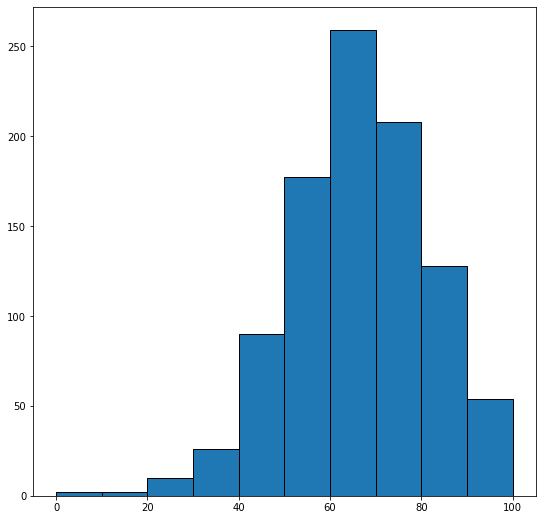

In [43]:
#Graphs using matplotlib and pandas dataframe
import numpy as np                       #only to check the median vlaue
import matplotlib.pyplot as plt

#Importing the PySpark Dataframe to Pandas Dataframe for making it usable with matplotlib
#renaming 'math score' to 'mathScore' as it throws error entered with space in the ax.hist() code
pandDF = df6.toPandas()
pandasDF = pandDF.rename(columns={'math score': 'mathScore'})
#pandasDF

#plotting graph | Method 1(ax.hist())
fig, ax = plt.subplots(figsize=(9,9))
ax.hist(pandasDF.mathScore, bins=10, edgecolor='black')

#method 2 (dataframe.hist())
#pandasDF.hist('mathScore', bins=100, edgecolor='black')


<AxesSubplot:xlabel='sepal_length', ylabel='sepal_width'>

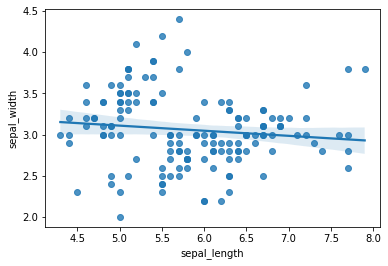

In [44]:
# Example Seaborn Graph!
import seaborn as sns
# load iris dataset using seaborn
pdf = sns.load_dataset('iris')
# use the function regplot to make a scatterplot
sns.regplot(x=pdf["sepal_length"],y=pdf["sepal_width"])

In [45]:
In VS code to make code run like it is running in cells do this, pase code velow in vs code
# %%
# Example Seaborn Graph!
import seaborn as sns
# load iris dataset using seaborn
pdf = sns.load_dataset('iris')
# use the function regplot to make a scatterplot
sns.regplot(x=pdf["sepal_length"],y=pdf["sepal_width"])

# %%
# Example Seaborn Graph!
import seaborn as sns
# load iris dataset using seaborn
pdf = sns.load_dataset('iris')
# use the function regplot to make a scatterplot
sns.regplot(x=pdf["sepal_length"],y=pdf["sepal_width"])

SyntaxError: invalid syntax (Temp/ipykernel_1824/1169049057.py, line 1)